In [1]:
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers.core import Dropout, Flatten, Activation, Dense
from tensorflow.python.keras.layers.convolutional import Convolution2D
from tensorflow.python.keras.layers.pooling import MaxPooling2D

In [2]:
train_df = pd.read_csv("./Eccv2010.csv", sep=",", index_col=False)
train_df['purpose'] = 'train'
np.random.seed(12) #important for reproducability
val_set_size = int((20*train_df.shape[0])/100)
val_idx = np.random.choice(train_df.shape[0], size=val_set_size)
test_set_size = int((50*val_idx.shape[0])/100)
test_idx = np.random.choice(val_idx.shape[0], size=test_set_size)
train_df.loc[val_idx, 'purpose'] = 'validation'
train_df.loc[test_idx, 'purpose'] = 'test'
 
df = train_df
 
df.sample(10)

,index,filename,score,num_ratings,purpose
469,469,hotornot_face/female_20_BRRYRMB_face_0.jpg,1.095278,6,train
659,659,hotornot_face/female_21_RRO8ERA_face_2.jpg,-0.282844,6,train
67,67,hotornot_face/female_18_BZRLKYA_face_0.jpg,0.055059,9,test
1868,1868,hotornot_face/female_24_AEOYBQK_face_1.jpg,0.073496,4,train
1404,1404,hotornot_face/female_18_RRRUHEA_face_0.jpg,0.792001,5,train
1554,1554,hotornot_face/female_18_AZNUEMA_face_0.jpg,0.015437,8,validation
1485,1485,hotornot_face/female_24_AZAQRSE_face_2.jpg,-1.275796,5,train
324,324,hotornot_face/female_19_AZA8OLK_face_1.jpg,1.375965,8,test
1242,1242,hotornot_face/female_33_RLOSSZR_face_1.jpg,-0.745809,7,train
911,911,hotornot_face/female_24_RRHSGQB_face_0.jpg,-2.182065,7,validation


In [3]:
def retrievePixels(img_name):
    path = "./Eccv2010_data/%s" % (img_name)
    img = preprocessing.image.load_img(path, grayscale=False, target_size=(224, 224))
    x = preprocessing.image.img_to_array(img).reshape(1, -1)[0]
    return x
 
df['pixels'] = df['filename'].apply(retrievePixels)

features = []
pixels = df['pixels'].values
for i in range(0, pixels.shape[0]):
    features.append(pixels[i])
 
features = np.array(features)
features = features.reshape(features.shape[0], 224, 224, 3)
features = features / 255 #normalize inputs within [0, 1]

In [4]:
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

from keras.models import model_from_json
#load pre-trained weights of vgg-face model.
#you can find it here: https://drive.google.com/file/d/1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo/view?usp=sharing
#related blog post: https://sefiks.com/2018/08/06/deep-face-recognition-with-keras/
model.load_weights('./vgg_face_weights.h5')

In [5]:
num_of_classes = 1 #this is a regression problem
 
#freeze all layers of VGG-Face except last 7 one
for layer in model.layers[:-7]:
    layer.trainable = False
 
base_model_output = Sequential()
base_model_output = Flatten()(model.layers[-4].output)
base_model_output = Dense(num_of_classes)(base_model_output)
 
beauty_model = Model(inputs=model.input, outputs=base_model_output)

beauty_model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam())
 
checkpointer = ModelCheckpoint(
    filepath='eccv_resize_beauty_model.hdf5'
    , monitor = "val_loss"
    , verbose=1
    , save_best_only=True
    , mode = 'auto'
)

earlyStop = EarlyStopping(monitor='val_loss', patience=50)

In [6]:
train_idx = df[(df['purpose'] == 'train')].index
val_idx = df[(df['purpose'] == 'validation')].index
test_idx = df[(df['purpose'] == 'test')].index

In [7]:
score = beauty_model.fit(
    features[train_idx], df.iloc[train_idx].score
    , epochs=200
    , validation_data=(features[val_idx], df.iloc[val_idx].score)
    , callbacks=[checkpointer, earlyStop]
)

Epoch 1/200
49/49 [==============================] - 157s 3s/step - loss: 1.4167 - val_loss: 1.1649

Epoch 00001: val_loss improved from inf to 1.16492, saving model to eccv_resize_beauty_model.hdf5
Epoch 2/200
49/49 [==============================] - 90s 2s/step - loss: 0.8961 - val_loss: 1.1169

Epoch 00002: val_loss improved from 1.16492 to 1.11685, saving model to eccv_resize_beauty_model.hdf5
Epoch 3/200
49/49 [==============================] - 90s 2s/step - loss: 0.7207 - val_loss: 1.0434

Epoch 00003: val_loss improved from 1.11685 to 1.04344, saving model to eccv_resize_beauty_model.hdf5
Epoch 4/200
49/49 [==============================] - 91s 2s/step - loss: 0.4790 - val_loss: 1.0389

Epoch 00004: val_loss improved from 1.04344 to 1.03891, saving model to eccv_resize_beauty_model.hdf5
Epoch 5/200
49/49 [==============================] - 91s 2s/step - loss: 0.3580 - val_loss: 1.0572

Epoch 00005: val_loss did not improve from 1.03891
Epoch 6/200
49/49 [=========================

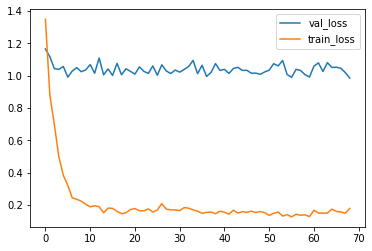

In [8]:
best_iteration = np.argmin(score.history['val_loss'])+1
val_scores = score.history['val_loss'][0:best_iteration]
train_scores = score.history['loss'][0:best_iteration]
 
plt.plot(val_scores, label='val_loss')
plt.plot(train_scores, label='train_loss')
plt.legend(loc='upper right')
plt.show()

In [10]:
actuals = df.iloc[test_idx].score.values
predictions = beauty_model.predict(features[test_idx])
 
perf = pd.DataFrame(actuals, columns = ["actuals"])
perf["predictions"] = predictions
print("PC: ",perf[['actuals', 'predictions']].corr(method ='pearson').values[0,1])
print("MAE: ", mean_absolute_error(actuals, predictions))
print("RMSE: ", sqrt(mean_squared_error(actuals, predictions)))
perf.to_csv('./Eccv2010_Resize_prediction.csv', index=False)

PC:  0.5260212229986846
MAE:  0.7260417351033167
RMSE:  0.930340096333867
